In [1]:
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.hysteresis import *

# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )


from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu
from OSCC_postprocessing.filters.bilateral_filter import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy

from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
from OSCC_postprocessing.binary_ops.masking import *
from OSCC_postprocessing.filters.convolution_2D_rawKernel import *
from OSCC_postprocessing.analysis.hysteresis import * 
from OSCC_postprocessing.filters.bilateral_filter_rawKernel import *

def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


In [2]:
# The only manual inputs in this file
file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T26\1.cine")
json_file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T2\config.json")

chamber_mask = ~((np.load(Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\mask_nozzle1.npy"))))

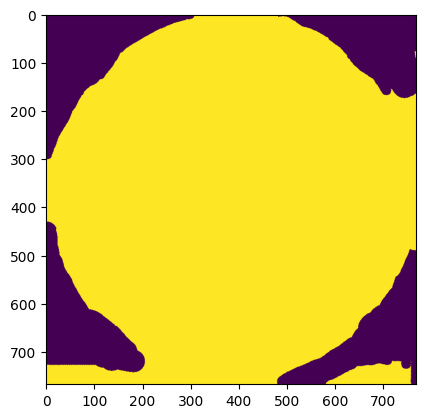

In [3]:
plt.imshow(chamber_mask)

In [4]:
# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits
gamma = 1.0

frames_before_SOI = 10

tp_num = int(file.parts[-2].replace("T", ""))

if tp_num == 1 or tp_num == 10 or tp_num == 19:
    frame_limit = 80
else:
    frame_limit = 50 

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=frame_limit)
# Normalize the grayscale video to [0, 1] brightness range
video = xp.asarray(video)/ brightness_levels





F, H, W = video.shape

# Json file contains the metadata
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 50
The injector has 10 plumes.
The nozzle is centred at (392.50, 378.37) in image coordinates.


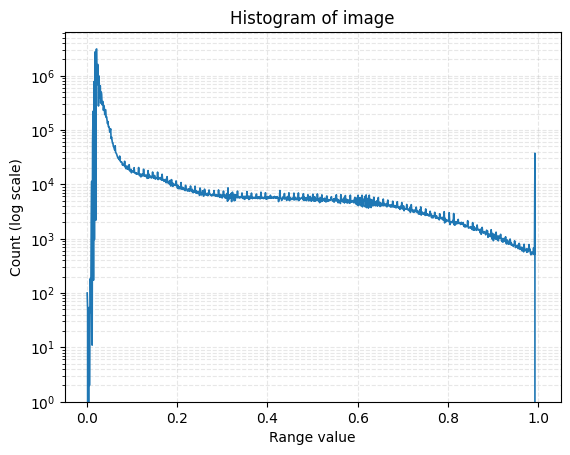

In [5]:
imhist(_as_numpy(video), log=True)

Text(0.5, 1.0, 'Ring mask based on calibrated inner & outer radius')

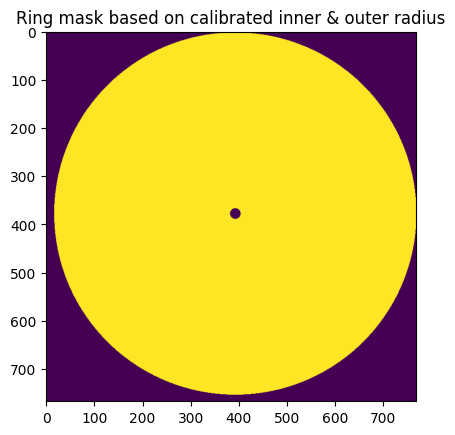

In [6]:
# Create annular mask between inner and outer radius to focus on spray region
ring_mask = generate_ring_mask(H, W, centre, ir_, or_, xp)
plt.imshow(_as_numpy(ring_mask))
plt.title("Ring mask based on calibrated inner & outer radius")

In [7]:
eps = 1e-9
lg_video = xp.log(video + eps)
lg_bkg = xp.median(lg_video[:frames_before_SOI], axis=0, keepdims=True)
log_ratio = lg_video - lg_bkg
dff = xp.expm1(log_ratio)

In [8]:
play_video_cv2(dff.get())

In [9]:
multiplier = 3
raw_bkg = xp.exp(lg_bkg)
noise_floor_mask = video > (raw_bkg * multiplier) # 1.5 是经验值，可调，表示只有亮度超过背景50%的像素才被视为有效


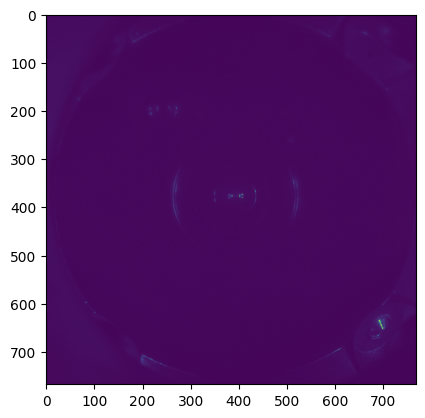

In [10]:
plt.imshow(raw_bkg.get().squeeze())

In [11]:
dff *= noise_floor_mask

# === 4. [核心优化] Baseline Alignment & Soft Thresholding ===
# 对齐基线
baseline = xp.median(dff[:frames_before_SOI], axis=0, keepdims=True)
dff -= baseline


In [12]:
play_video_cv2(dff.get())

In [13]:


# [关键]: 使用 Soft Thresholding 代替 Hard Clip
# Hard Clip (x < 0 -> 0) 会产生折角，高通滤波会把折角识别为高频信号。
# Softplus 或 ReLU 的平滑变体可以保持导数连续性。
# 这里我们使用一个简单的平滑过渡：
# 只有当信号显著大于 0 时才保留，微小的正负波动都视为 0

threshold = 0.05 # 过滤掉 5% 以下的微小 dF/F 波动
# 软阈值公式: sign(x) * max(|x| - thresh, 0) -> 仅保留正向部分则变为 max(x - thresh, 0)
# 但为了更平滑，我们可以用 xp.maximum(dff - threshold, 0) 
# 或者更进一步，使用 Softplus: log(1 + exp(k*x))

dff_clean = xp.maximum(dff - threshold, 0)

# === 5. Scale ===
# 使用之前定义的鲁棒缩放
final_output = robust_scale(dff_clean, q_min=5, q_max=100) # q_min可以略低，因为我们要保留0


In [14]:
play_video_cv2(final_output.get())

In [15]:
def refined_log_subtraction(video, frames_before_SOI, xp):
    eps = 1e-9
    
    # === 1. Log Space Conversion ===
    lg_video = xp.log(video + eps)

    # [优化点 1]: 使用 Median 代替 Mean
    # 理由：背景估计不应受到偶尔出现的亮点（如宇宙射线或非特异性闪烁）的影响。
    # Median 在统计上对异常值更鲁棒。
    lg_bkg = xp.median(lg_video[:frames_before_SOI], axis=0, keepdims=True)

    # === 2. Calculate dF/F in Log Space ===
    # 数学推导：log(V) - log(B) = log(V/B)
    # exp(log(V/B)) - 1 = V/B - 1 = (V - B) / B = dF/F0
    # 使用 expm1 (exp(x) - 1) 在 x 接近 0 时精度更高
    log_ratio = lg_video - lg_bkg
    dff = xp.expm1(log_ratio)

    # === 3. [核心优化] Intensity Gating (强度门控) ===
    # 理由：你提到需要把暗部变0或梯度变平。
    # 仅仅依靠 dff 无法区分 "暗部的噪声波动" 和 "亮部的微弱信号"。
    # 我们必须利用原始亮度信息。
    
    # 计算背景的绝对亮度阈值 (比如背景中位数的 1.2 倍作为噪声底)
    # 注意：这里是在线性空间计算阈值
    raw_bkg = xp.exp(lg_bkg)
    noise_floor_mask = video > (raw_bkg * 1.5) # 1.5 是经验值，可调，表示只有亮度超过背景50%的像素才被视为有效
    
    # 应用门控：将暗部区域平滑过渡到 0
    # 这里使用乘法掩膜，不仅处理了值，也平滑了梯度
    dff *= noise_floor_mask

    # === 4. [核心优化] Baseline Alignment & Soft Thresholding ===
    # 对齐基线
    baseline = xp.median(dff[:frames_before_SOI], axis=0, keepdims=True)
    dff -= baseline

    # [关键]: 使用 Soft Thresholding 代替 Hard Clip
    # Hard Clip (x < 0 -> 0) 会产生折角，高通滤波会把折角识别为高频信号。
    # Softplus 或 ReLU 的平滑变体可以保持导数连续性。
    # 这里我们使用一个简单的平滑过渡：
    # 只有当信号显著大于 0 时才保留，微小的正负波动都视为 0
    
    threshold = 0.05 # 过滤掉 5% 以下的微小 dF/F 波动
    # 软阈值公式: sign(x) * max(|x| - thresh, 0) -> 仅保留正向部分则变为 max(x - thresh, 0)
    # 但为了更平滑，我们可以用 xp.maximum(dff - threshold, 0) 
    # 或者更进一步，使用 Softplus: log(1 + exp(k*x))
    
    dff_clean = xp.maximum(dff - threshold, 0)

    # === 5. Scale ===
    # 使用之前定义的鲁棒缩放
    final_output = robust_scale(dff_clean, q_min=5, q_max=99.99) # q_min可以略低，因为我们要保留0

    return final_output

In [ ]:
def mie_multihole_preprocessing(
                                video, 
                                ring_mask,
                                wsize=3,
                                sigma=1.0,
                                chamber_mask=None,
                                binarize_each_frame_after_peak=False
                                ):
        

        lg_foreground = refined_log_subtraction(video, frames_before_SOI, xp)
        # === Apply the mask ===
        # lg_foreground_masked = lg_foreground * ring_mask[None, :, :]
        
        # === Highpass filter ===
        sobel_x = make_kernel("sobel", wsize, sigma, direction="x")
        sobel_y = make_kernel("sobel", wsize, sigma, direction="y")

        
        sb_filt_x = convolution_2D_cupy(lg_foreground, sobel_x)
        sb_filt_y = convolution_2D_cupy(lg_foreground, sobel_y)
        sb_mag = xp.sqrt(sb_filt_x ** 2 + sb_filt_y ** 2)

        # Scale linearly to [0, 1]
        # lg_foreground_highpass = _min_max_scale(sb_mag)
        lg_foreground_highpass = robust_scale(sb_mag, q_min=5, q_max=99.9999)
        
        # Frame-wise sum
        energy_highpass = xp.sum(lg_foreground_highpass, axis=(1,2))

        # Find the brightest frame and their intensity for each plume
        brightness_peaks = _as_numpy(xp.argmax(energy_highpass).item())

        # Normalize the intensity of the brightest frame to 1 for each plume
        peak_intensity_sums = xp.max(energy_highpass)
        energy_highpass /= peak_intensity_sums


        # lg_foreground_highpass_compensated = bilateral_filter_video_cupy_fast(lg_foreground_highpass, 3, 3,1)
        lg_foreground_highpass_compensated =  lg_foreground_highpass

        # Binairzing the whole video
        bw_foreground_unified = xp.zeros_like(video)

        # === Global Threshold ===
        bw_foreground_unified = triangle_binarize_gpu(lg_foreground_highpass_compensated)

        # === Per Frame Threshold ===

        if binarize_each_frame_after_peak:
            # Global Threshold up to peak intensity frame
            # bw_foreground_unified[:int(brightness_peaks)] = triangle_binarize_gpu(lg_foreground_highpass[:int(brightness_peaks)]) 

            for f in range(F):
                if f >= int(brightness_peaks):
                    bw_foreground_unified[f] = triangle_binarize_gpu(lg_foreground_highpass[f]) 
            

        '''
        # Experiment with using the brightest frame as global threshold
        _, thres = triangle_binarize_from_float(lg_foreground_highpass[int(brightness_peaks)].get())
        
        bw_foreground_unified = lg_foreground_highpass >= thres /255.0
        '''
        lg_foreground*= ring_mask[None, :, :]
        
        lg_foreground_highpass_compensated *= ring_mask[None, :, :]

        bw_foreground_unified*= ring_mask[None, :, :] 

        if chamber_mask is not None:
            chamber_mask = xp.asarray(chamber_mask)
            lg_foreground_highpass_compensated *= chamber_mask[None, :, :]

            bw_foreground_unified*= chamber_mask[None, :, :]

        return lg_foreground, lg_foreground_highpass_compensated, bw_foreground_unified

In [17]:
fg, hp, bw = mie_multihole_preprocessing(
                                video, 
                                ring_mask,
                                wsize=3,
                                sigma=1,
                                chamber_mask=chamber_mask,
                                binarize_each_frame_after_peak=False
                                )

In [18]:
play_videos_side_by_side((_as_numpy(fg), _as_numpy(20.0*hp), _as_numpy(bw*255.0)), intv=150)

In [19]:
# bw_opened = cndi.binary_fill_holes(bw, cp.ones((1,49, 49)))

In [20]:
# play_videos_side_by_side((_as_numpy(255.0*(bw)), _as_numpy(255.0*bw_opened)), intv=150)

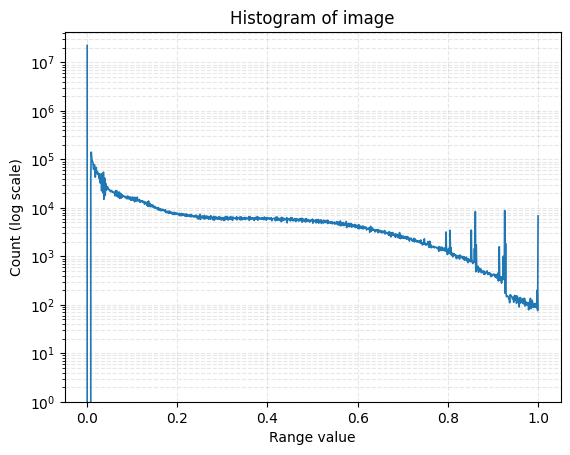

In [21]:
imhist(_as_numpy(fg), log=True)

In [22]:
# === Angular Signal Density Analysis ===
# Use 720 bins for 0.5 degree resolution
bins = 720
# scale = bins / 360.0
'''
# Compute angular signal distribution around the nozzle centre
_, total_angular_signal_density, _ = angle_signal_density_auto(
    fg*ring_mask[None, :, :], centre[0], centre[1], N_bins=bins
)
'''
# Compute angular signal distribution around the nozzle centre
_, total_angular_signal_density, _ = angle_signal_density_auto(
    fg*ring_mask[None, :, :], centre[0], centre[1], N_bins=bins
)

# === Find Optimal Rotation Offset ===
# Use FFT to find the best offset that aligns with plume periodicity
offset = estimate_offset_from_fft(total_angular_signal_density, number_of_plumes)

# Calculate rotation angles for each plume (evenly spaced with offset correction)
angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - _as_numpy(offset)

# === Compute Occupied Angles ===
# Create bin-wise mask and fill small gaps to get continuous plume regions
bin_wise_mask = fill_short_false_runs(
    _triangle_binarize_gpu(xp.sum(total_angular_signal_density, axis=0), ignore_zeros=True), 
    max_len=3
    )

# Calculate angular span of each plume region
occupied_angles = periodic_true_segment_lengths(bin_wise_mask)
# Average angular width per plume in degrees
average_occupied_angle = (bin_wise_mask.sum() / bins * 360.0 / number_of_plumes).item()

# Generate 2D angular mask from the 1D signal density
angular_mask = generate_angular_mask_from_tf(H, W, centre, total_angular_signal_density, bins)

ang_int_sum = _min_max_scale(xp.sum(total_angular_signal_density, axis=0))


In [23]:
from OSCC_postprocessing.analysis.cone_angle import snap_angles_to_local_maxima

angles_refined = snap_angles_to_local_maxima(angles, ang_int_sum, window_deg=2.0, bins=bins)
TF = triangle_binarize_gpu(median_filter(ang_int_sum, 5))

average_occupied_angle = TF.sum()/bins*360.0/number_of_plumes


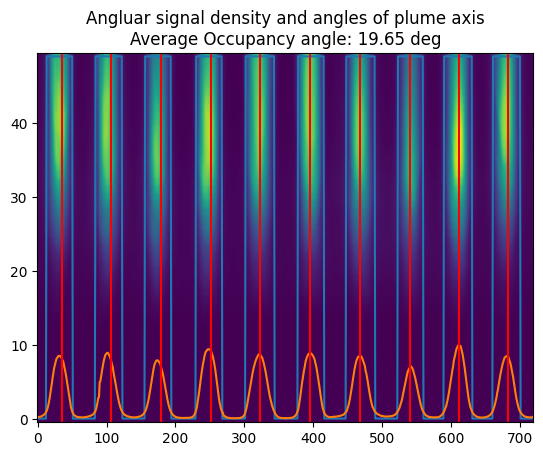

In [24]:

plt.imshow(_as_numpy(total_angular_signal_density), origin="lower", aspect="auto")


plt.plot(TF.get()*(total_angular_signal_density.shape[0]-1))

plt.plot(_as_numpy(median_filter(ang_int_sum, 3)) * 10.0)
for angle in angles_refined:

    if angle > 0.0:
        plt.axvline(angle * (bins / 360.0), color="r")
    else:
        plt.axvline(bins + angle * (bins / 360.0), color="r")

plt.title(f"Angluar signal density and angles of plume axis\nAverage Occupancy angle: {average_occupied_angle:.2f} deg")
plt.show()

In [25]:
# Rotation
 
# Frames, Height, Width
F, H, W = video.shape

# Allocate collector
segments = []

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (H // 4, W//2)


for idx, angle in enumerate(angles):
    segment, _, _ = rotate_video_nozzle_at_0_half_backend(
            hp,
            centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
            # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
            angle,
            interpolation=INTERPOLATION,
            border_mode=BORDER_MODE,
            out_shape=OUT_SHAPE,
        )
    segments.append(segment)

segments_fg = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)

P, F, H, W = segments_fg.shape


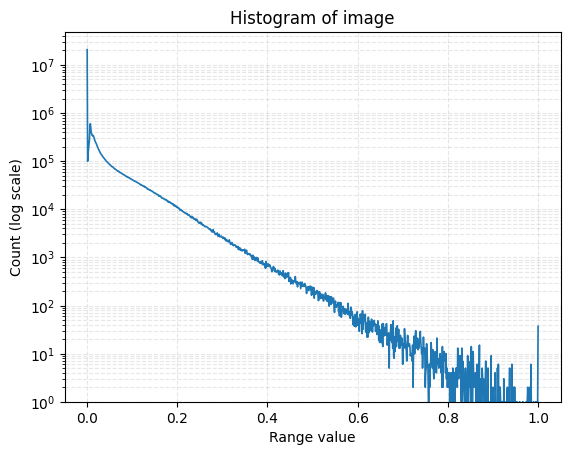

In [26]:
imhist(segments_fg.get(),log=True)

In [27]:

segments_fg = robust_scale(segments_fg, q_min=50, q_max=100)

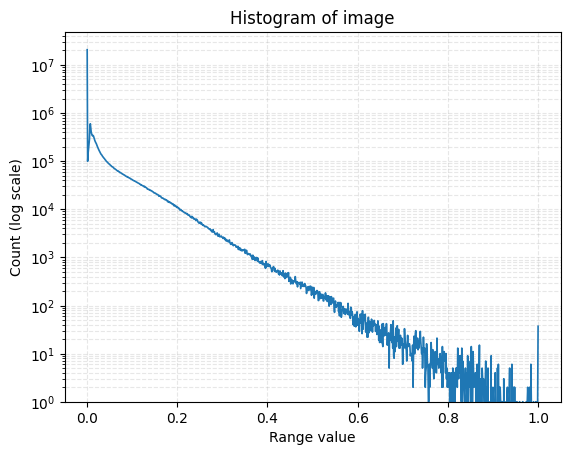

In [28]:
imhist(segments_fg.get(),log=True)

In [29]:
# play_videos_side_by_side((xp.swapaxes(segments_fg*10.0, 2, 3).get().tolist()), intv=50)

In [30]:
plume_mask = generate_plume_mask(W, H, average_occupied_angle.get()*1.5, int(ir_))
segments_fg *= xp.asarray(plume_mask[None, None, :, :])

heatmaps = xp.sum(xp.clip(segments_fg, 0, 1), axis=2) # P, F, W


In [31]:
# gain

gain = 1.0

lighting_correction = xp.mean(heatmaps[:, :frames_before_SOI, :], axis=1, keepdims=True)

eps = 1e-4
# Shape P, W
lighting_correction = xp.clip(lighting_correction, 0, 1) + eps
#heatmaps /= lighting_correction



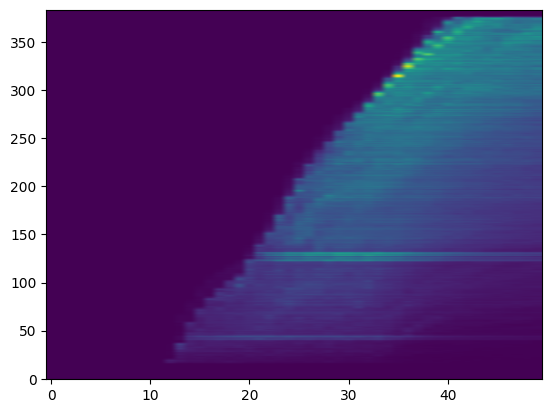

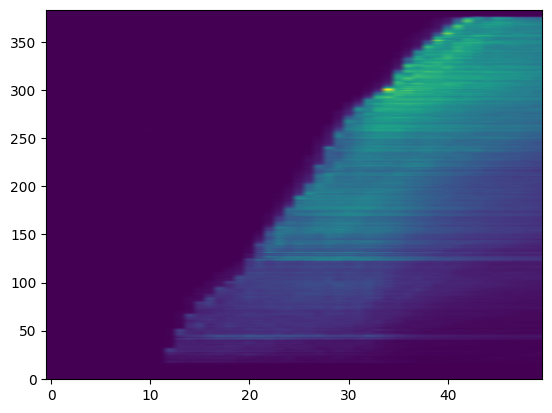

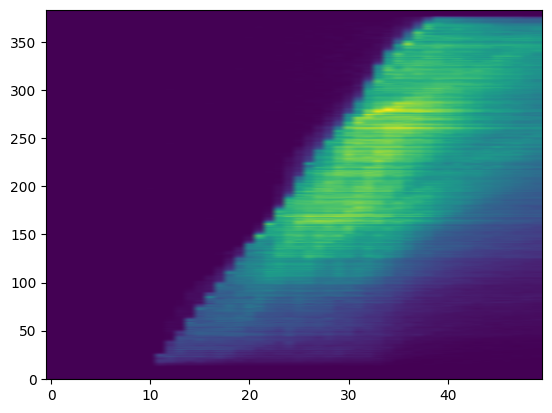

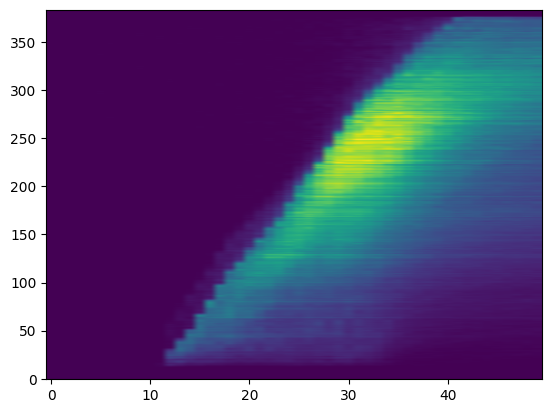

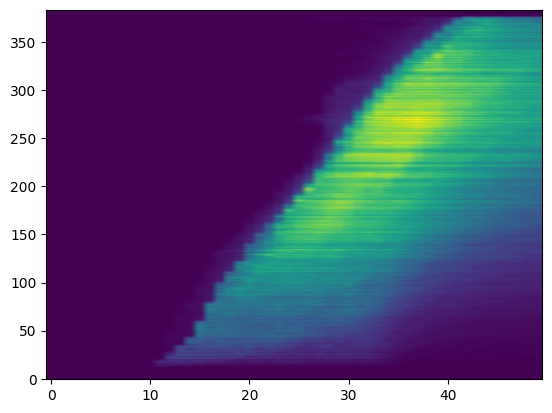

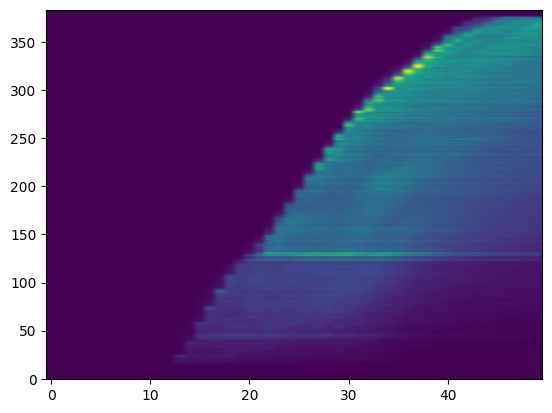

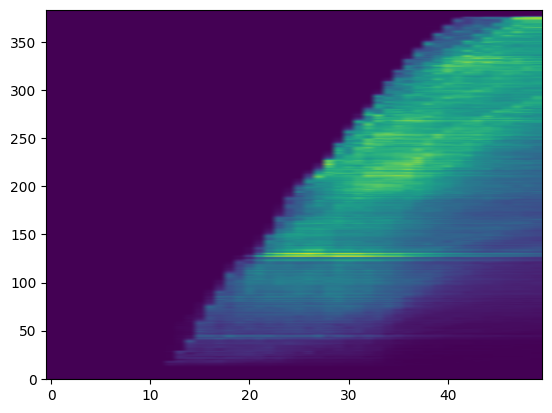

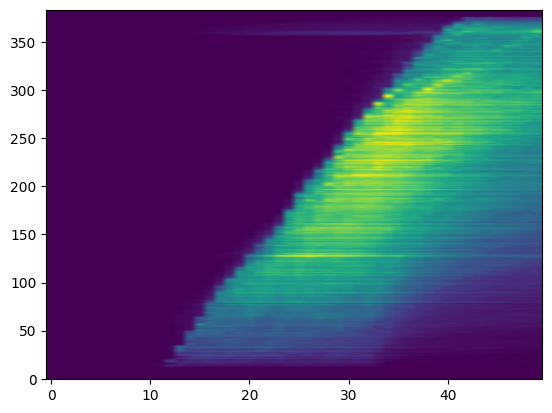

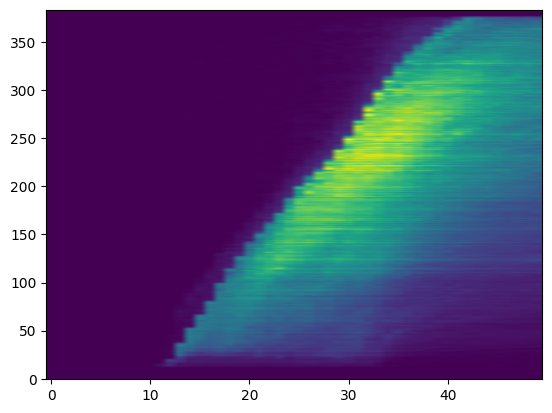

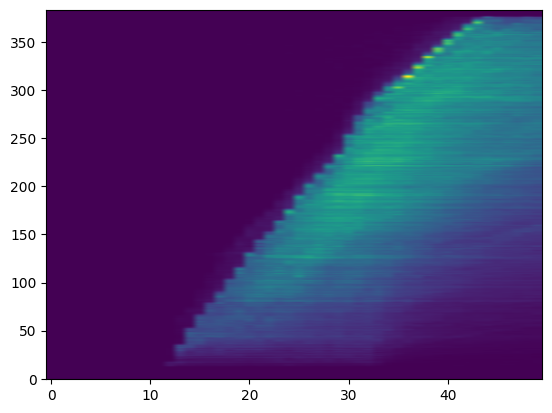

In [32]:


# penetration_bw_td = xp.zeros_like(heatmaps)

for idx, td_map in enumerate(heatmaps):
    heatmaps[idx] = _min_max_scale(heatmaps[idx])
    # penetration_bw_td[idx] = keep_largest_component_cuda(_triangle_binarize_gpu((heatmaps[idx])))
    plt.imshow(_as_numpy(heatmaps[idx]).T, origin="lower", aspect="auto")
    plt.show()


In [33]:
for idx in range(len(heatmaps)):
    # Retrieve data
    I = heatmaps[idx]
    mask = triangle_binarize_gpu(_min_max_scale(I))
    
    # Process mask
    mask = 1 - (keep_largest_component_cuda(1 - mask))

mask.shape

(50, 384)

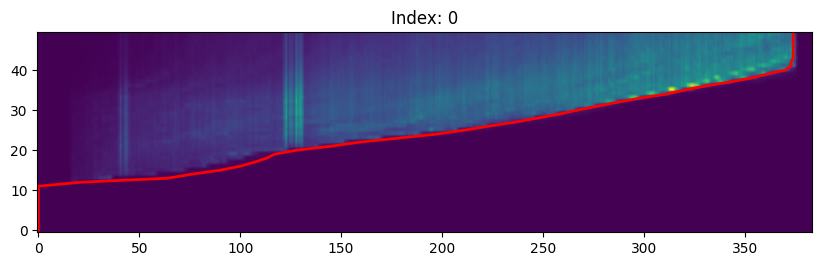

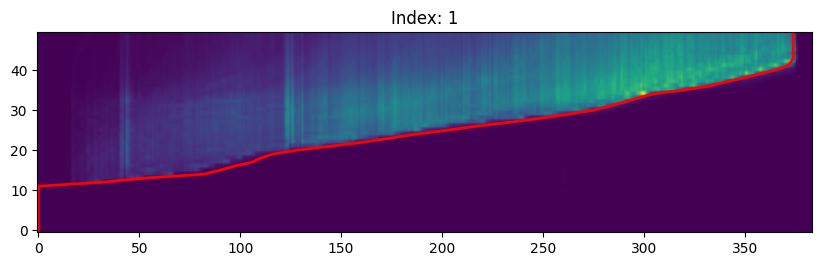

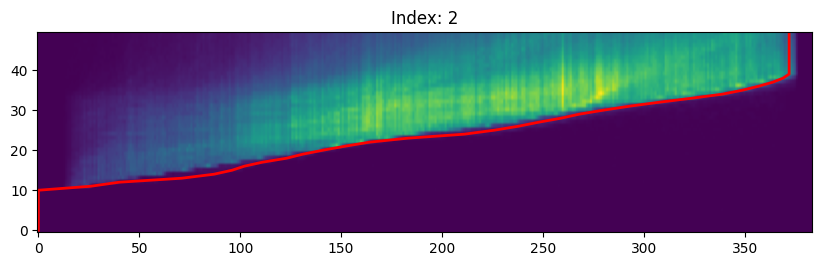

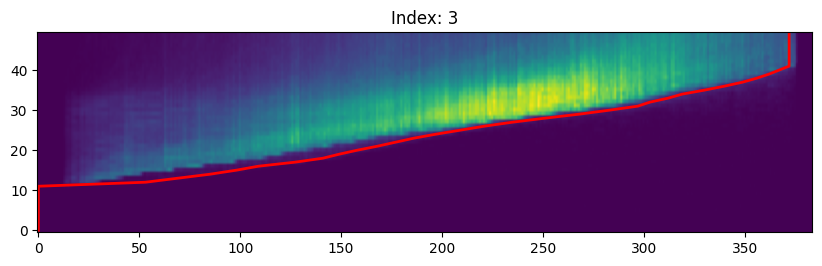

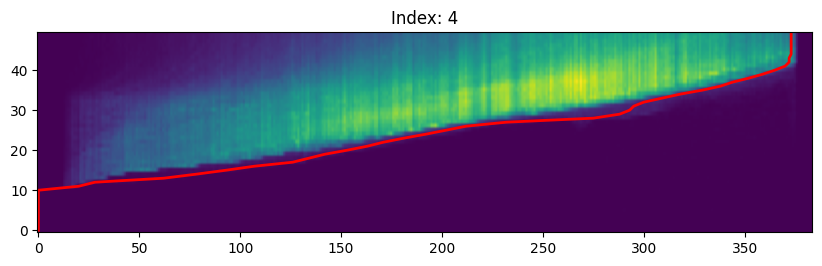

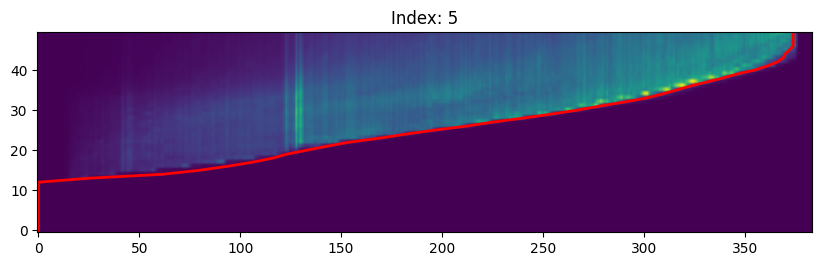

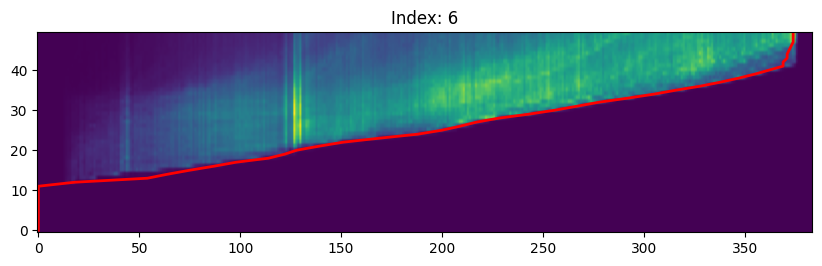

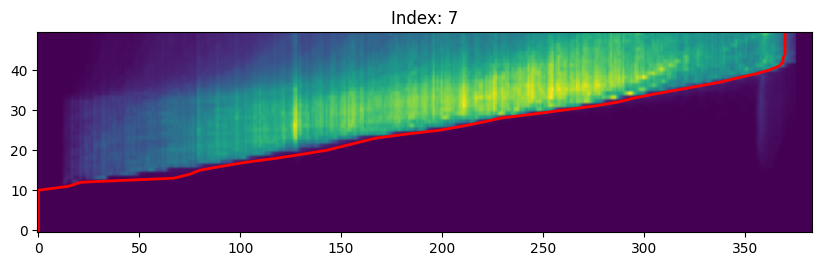

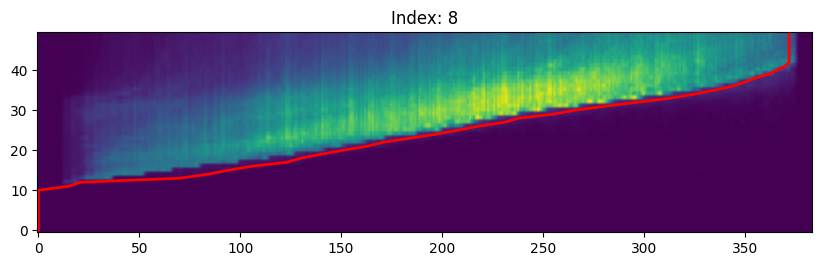

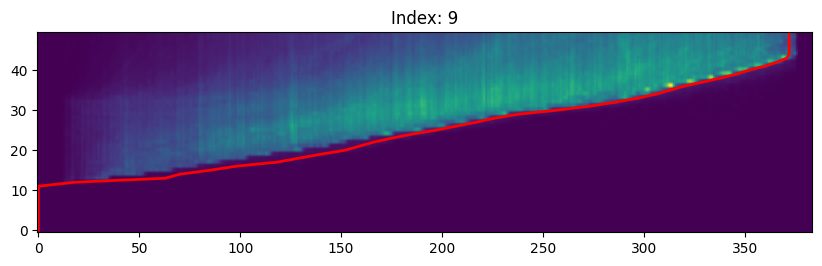

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from OSCC_postprocessing.analysis.penetration_cdf import penetration_cdf_front, monotone_non_decreasing

q = 1.0-1e-2
kernel_closing = cp.ones((7, 3))

# 1. Initialize the storage array with the same shape as penetration_td
# We assume penetration_td is already defined in your context
penetration_cdf_all = np.zeros((heatmaps.shape[0], heatmaps.shape[1]))


# 2. Iterate through all available indices
# We use the length of the map list to determine the range
for idx in range(len(heatmaps)):
    
    # Retrieve data
    I = heatmaps[idx]

    I -= xp.median(I[:, :frames_before_SOI], axis=1, keepdims=True)

    I = xp.clip(I, 0.0, None)

    
    mask = triangle_binarize_gpu(_min_max_scale(I))
    
    # Process mask
    mask = 1 - (keep_largest_component_cuda(1 - mask))

    mask = cndi.binary_opening(mask, kernel_closing)

    # Compute penetration curve
    xhat = penetration_cdf_front(I, mask=mask, q=q, min_x=10)
    pen0 = np.maximum.accumulate(xhat.get())

    # Store the result in the array
    # penetration_cdf_all[idx] = pen0
    penetration_cdf_all[idx] = pen0

    img = heatmaps[idx].get()

    # 3. Display the result
    plt.figure(figsize=(10, 2.6))
    # 
    plt.imshow(_as_numpy(I), origin="lower", aspect="auto")
    # plt.imshow(_as_numpy(mask), origin="lower", aspect="auto")
    plt.plot(pen0, np.arange(I.shape[0]), 'r-', lw=2)
    # pen_td = penetration_td[idx].get()
    # plt.plot(pen_td, np.arange(len(pen_td)), 'y--', lw=2)
    plt.title(f"Index: {idx}")
    plt.show()

# Now penetration_cdf_all contains the computed curves for all indices



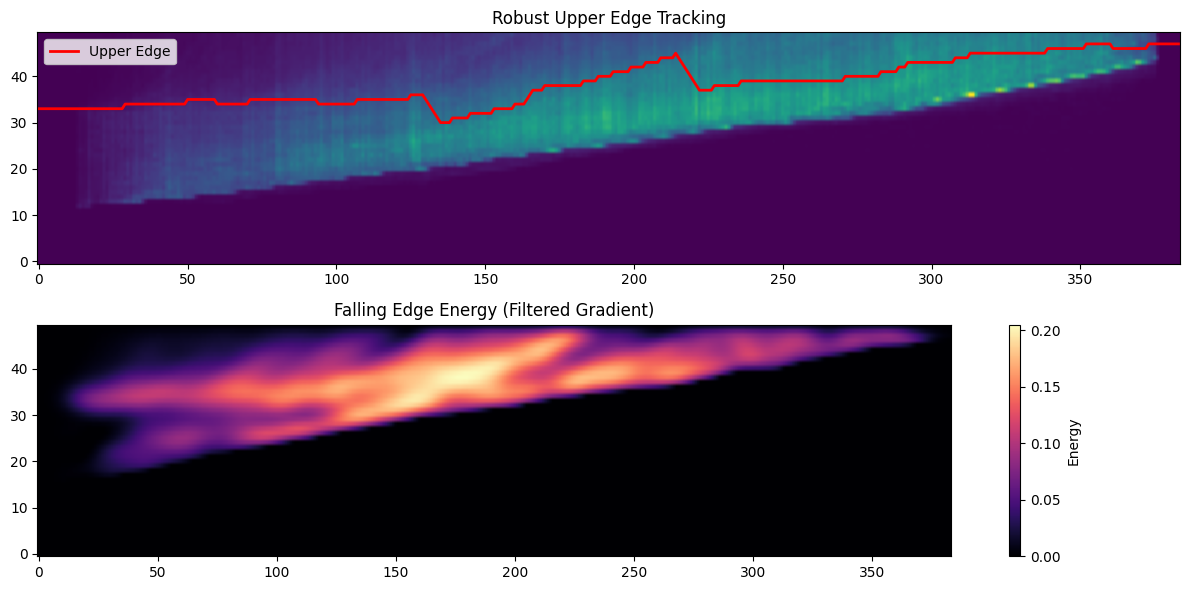

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, sobel

def track_upper_edge_robust(heatmap, sigma=(1, 4), smoothness=1):
    """
    针对中间亮、两头暗、且有衰减的数据追踪上边缘。
    
    参数:
    - sigma: 高斯模糊参数，(y_sigma, x_sigma)。
             Y方向大一点可以平滑层级，X方向大一点可以抵抗信号中断。
    - smoothness: 限制相邻列的跳变范围。
                  1 表示下一列的边缘只能在当前 y, y-1, y+1 中选择。
    """
    H, W = heatmap.shape
    
    # 1. 预处理
    img_smooth = gaussian_filter(heatmap, sigma=sigma)
    
    # 2. 计算垂直梯度 (Vertical Gradient, axis=0)
    # 注意：sobel(axis=0) 计算的是 y_{i+1} - y_{i}
    grad_y = sobel(img_smooth, axis=0)
    
    # 3. 关键逻辑：锁定上边缘
    # 上边缘的特征是：随着 Y 增大，亮度变小 (Bright -> Dark)
    # 这意味着梯度是负值。我们取负号，将其转化为正能量。
    # 这样，下边缘（正梯度）就会变成负值，被后面的 clip 过滤掉。
    energy = -grad_y 
    energy = np.clip(energy, 0, None) # 只保留下降沿，忽略上升沿和背景噪点
    
    # 可选：如果右侧衰减严重，可以对 energy 做列归一化(Column Normalization)
    # 但通常 DP 算法本身就能处理衰减，只要相对梯度依然存在。

    # 4. 动态规划 (Dynamic Programming) 从左到右
    # dp[y, x] 表示从左侧到达点 (y, x) 的最大累积能量
    dp = np.zeros_like(energy)
    backtrack = np.zeros_like(energy, dtype=int)
    
    # 初始化第一列
    dp[:, 0] = energy[:, 0]
    
    # 开始横向扫描
    for x in range(1, W):
        for y in range(H):
            # 搜索上一列的邻域范围
            y_start = max(0, y - smoothness)
            y_end = min(H, y + smoothness + 1)
            
            # 找上一列中，能跳到当前点的最大能量位置
            prev_slice = dp[y_start:y_end, x-1]
            best_local_idx = np.argmax(prev_slice)
            best_prev_y = y_start + best_local_idx
            
            dp[y, x] = energy[y, x] + dp[best_prev_y, x-1]
            backtrack[y, x] = best_prev_y
            
    # 5. 回溯路径
    edge_path = np.zeros(W)
    
    # 从最后一列找到能量最大的位置开始
    current_y = np.argmax(dp[:, -1])
    edge_path[-1] = current_y
    
    for x in range(W - 2, -1, -1):
        current_y = backtrack[int(current_y), x+1]
        edge_path[x] = current_y
        
    return edge_path, energy

# --- 使用示例 ---

# 假设 I 是当前图片数据
I = heatmaps[9].get() if hasattr(heatmaps[9], 'get') else heatmaps[9]

# 运行算法
# sigma=(2, 5) -> Y方向适度模糊定层，X方向大模糊以连接衰减的尾部信号
edge_y, energy_map = track_upper_edge_robust(I, sigma=(2, 5))

# --- 绘图 ---
plt.figure(figsize=(12, 6))

# 1. 叠加显示
plt.subplot(2, 1, 1)
plt.imshow(I, origin="lower", aspect="auto", cmap='viridis')
plt.plot(np.arange(len(edge_y)), edge_y, 'r-', lw=2, label='Upper Edge')
plt.title("Robust Upper Edge Tracking")
plt.legend()

# 2. 算法看到的“能量”
plt.subplot(2, 1, 2)
plt.imshow(energy_map, origin="lower", aspect="auto", cmap='magma')
plt.title("Falling Edge Energy (Filtered Gradient)")
plt.colorbar(label="Energy")

plt.tight_layout()
plt.show()

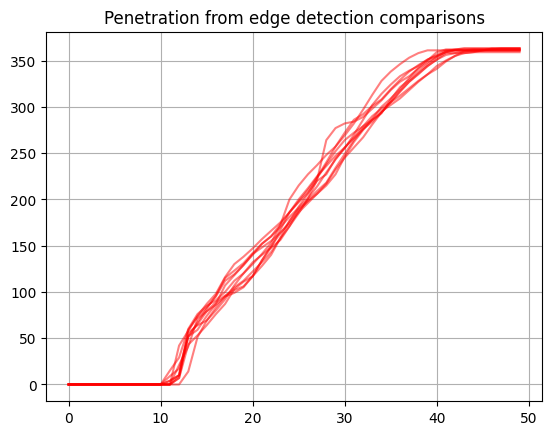

In [36]:
plt.plot(np.maximum(0, penetration_cdf_all.T-ir_), color="r", alpha=0.5, label="Penetration from CDF of highpass video heatmaps" )
plt.title("Penetration from edge detection comparisons")
plt.grid()

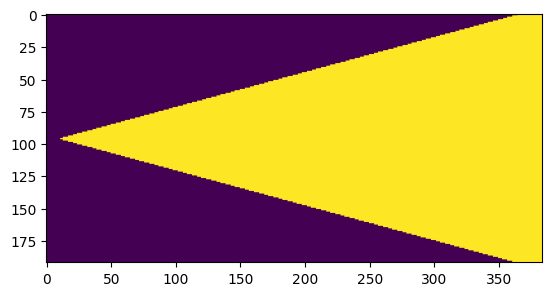

In [37]:
plt.imshow(plume_mask)

In [38]:
play_videos_side_by_side((xp.swapaxes(segments_fg*10.0, 2, 3).get().tolist()), intv=50)

In [39]:
# Rotation
 
# Frames, Height, Width
F, H, W = video.shape

# Allocate collector
segments = []

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (H // 4, W//2)


for idx, angle in enumerate(angles):
    segment, _, _ = rotate_video_nozzle_at_0_half_backend(
            bw,
            centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
            # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
            angle,
            interpolation=INTERPOLATION,
            border_mode=BORDER_MODE,
            out_shape=OUT_SHAPE,
        )
    segments.append(segment)

segments_bw = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)

segments_bw *= xp.asarray(plume_mask[None, None, :, :])

In [40]:
# play_videos_side_by_side((xp.swapaxes(segments_bw*255.0, 2, 3).get().tolist()), intv=50)

In [41]:
# Morphological operations
struct1 = cp.zeros((7, 7, 7), dtype=bool)
struct1[1, :, :] = True

struct2 = cp.ones((3,3,3), dtype=bool)

# Binarize and refine by filling the holes and closing the edges

bw_filled = xp.zeros_like(segments_bw)
 
for p in range(P):
    blob_3D = keep_largest_component_nd_cuda(
        cndi.binary_fill_holes(
            cndi.binary_closing(
                segments_bw[p], structure=struct1
            )
            , structure=struct2)
        )
    for f in range(F):
        bw_filled[p, f] = keep_largest_component_cuda(blob_3D[f])

In [42]:
# play_videos_side_by_side((xp.swapaxes(bw_filled*255.0, 2, 3).get().tolist()), intv=50)

In [43]:
bw_area = xp.sum(bw_filled, axis=(2,3))


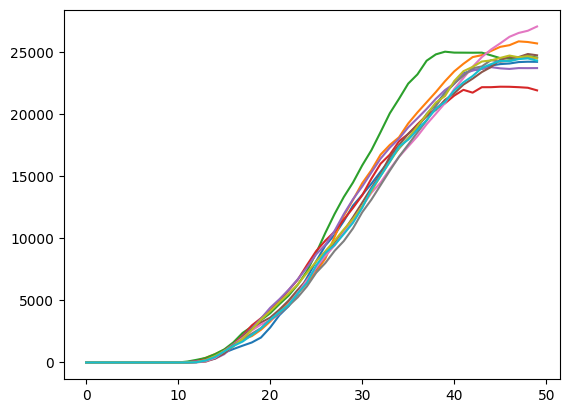

In [44]:
plt.plot(bw_area.T.get())

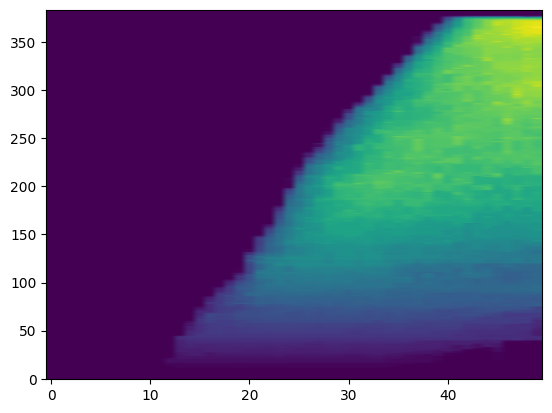

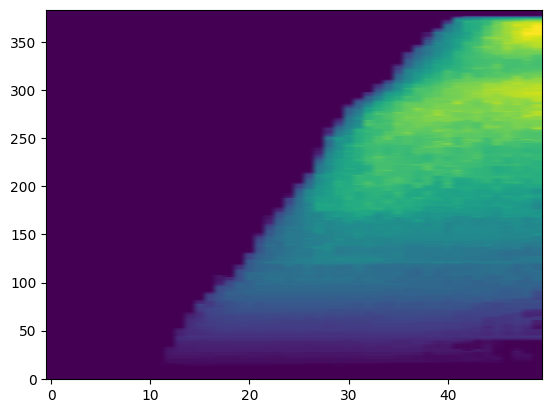

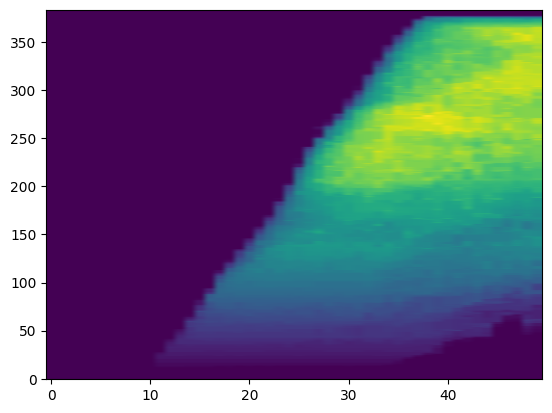

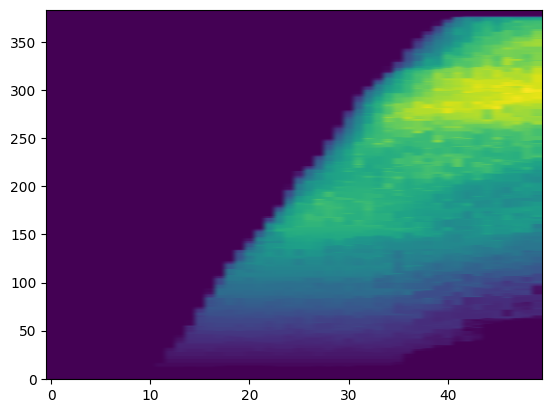

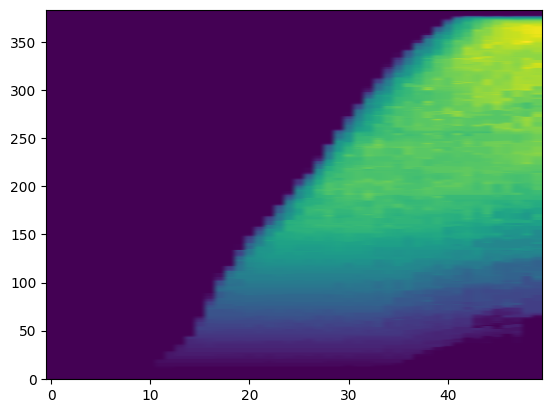

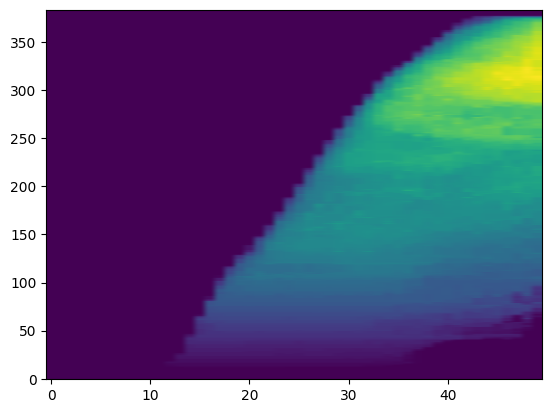

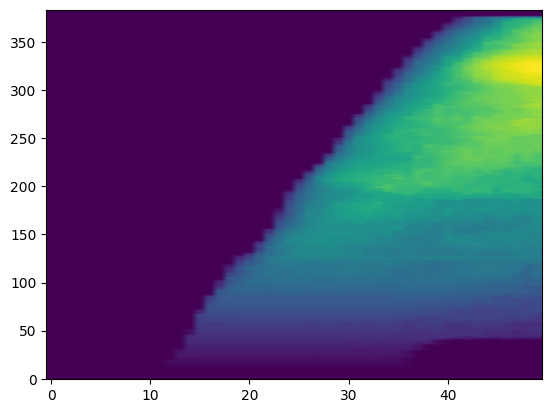

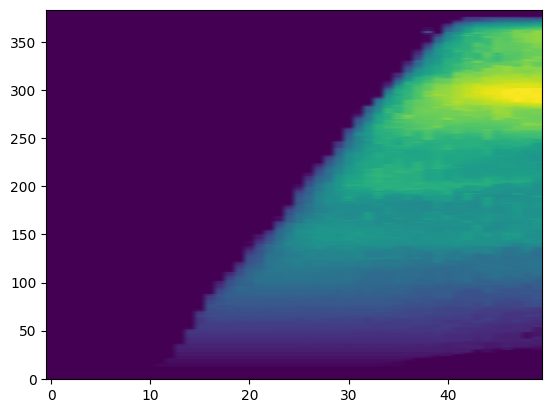

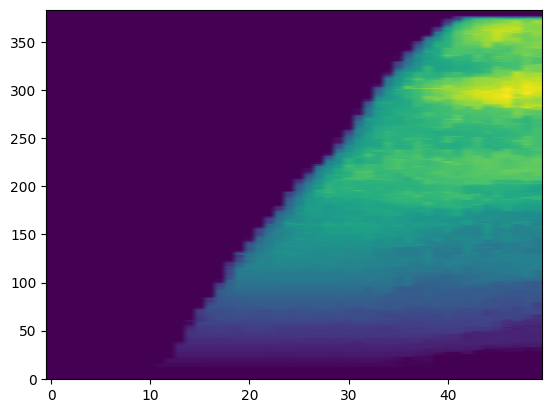

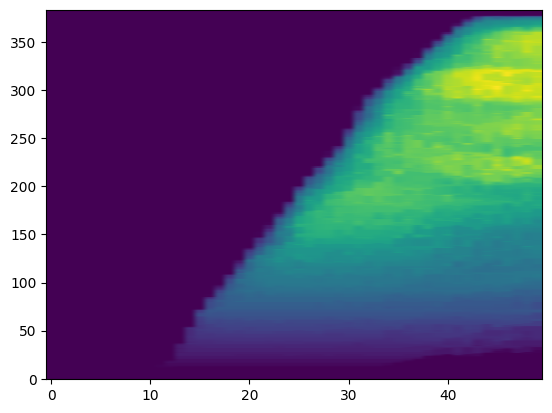

In [45]:
bw_heatmaps = xp.sum(bw_filled, 2)

for heatmap in bw_heatmaps:
    plt.imshow(heatmap.T.get(), aspect="auto", origin="lower")
    plt.show()



In [46]:
def calculate_penetration_bw_num_pixelsthreshold(segments_bw, inner_radius, outer_radius, thres_num_bw=1):

    edge_bw_col_sums = xp.sum(segments_bw, axis=2) > thres_num_bw

    pen_edge_bw = xp.swapaxes(edge_bw_col_sums , 1, 2)

    penetration_highpass = pen_edge_bw.shape[1] - cp.argmax(pen_edge_bw[:, ::-1, :], axis=1)
    penetration_highpass = penetration_highpass.astype(cp.float32)  # 或 cp.float64
    penetration_highpass[penetration_highpass >= outer_radius ] = cp.nan
    penetration_highpass -= inner_radius
    return penetration_highpass

(10, 50)

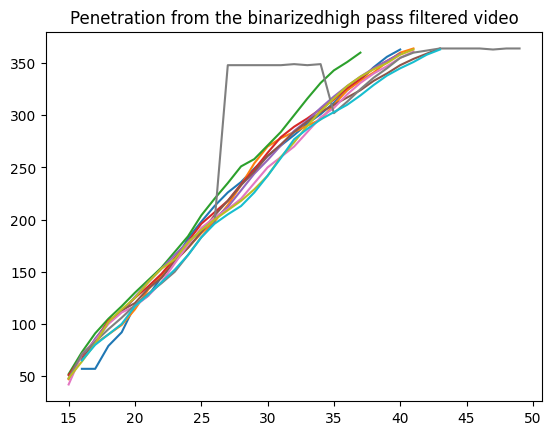

In [47]:

# Calculate the penetration from the time-distance intensity heatmap
penetration_highpass = calculate_penetration_bw_num_pixelsthreshold(segments_bw, ir_, or_, thres_num_bw=20)

plt.plot(_as_numpy(penetration_highpass.T))

plt.title("Penetration from the binarizedhigh pass filtered video")

penetration_highpass.shape

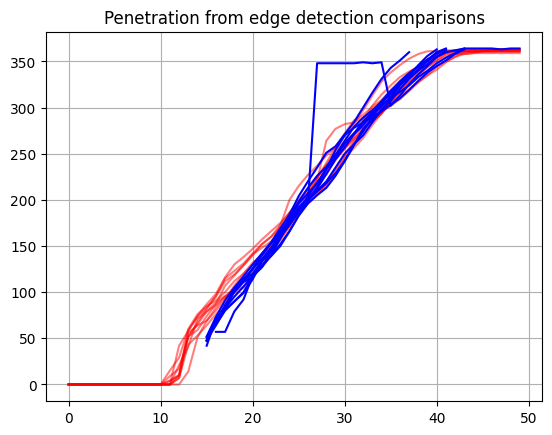

In [48]:
# Penetration Method comparison
plt.plot(np.maximum(0, penetration_cdf_all.T-ir_), color="r", alpha=0.5, label="Penetration from CDF of highpass video heatmaps" )
plt.plot(_as_numpy(penetration_highpass.T), color="b")

plt.title("Penetration from edge detection comparisons")
plt.grid()


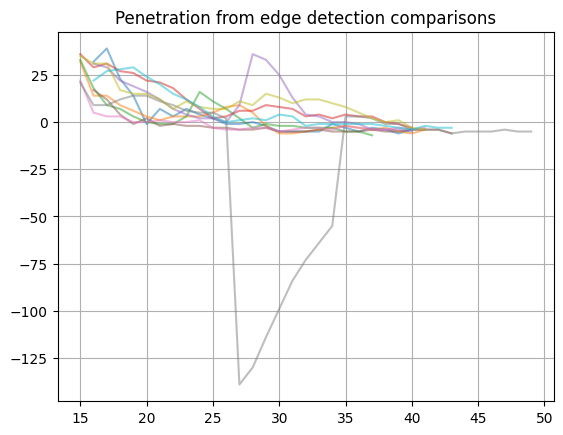

In [49]:
# Penetration Method comparison
plt.plot(np.maximum(0, penetration_cdf_all.T-ir_) - _as_numpy(penetration_highpass.T), alpha=0.5, label="Penetration from CDF of highpass video heatmaps" )

plt.title("Penetration from edge detection comparisons")
plt.grid()

In [50]:
# Rotation
 
# Frames, Height, Width
F, H, W = video.shape

# Allocate collector
segments = []

# Image rotation settings
INTERPOLATION = "bilinear"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (H // 4, W//2)


for idx, angle in enumerate(angles):
    segment, _, _ = rotate_video_nozzle_at_0_half_backend(
            video,
            centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
            # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
            angle,
            interpolation=INTERPOLATION,
            border_mode=BORDER_MODE,
            out_shape=OUT_SHAPE,
        )
    segments.append(segment)

segments_raw = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)

segments_raw *= xp.asarray(plume_mask[None, None, :, :])

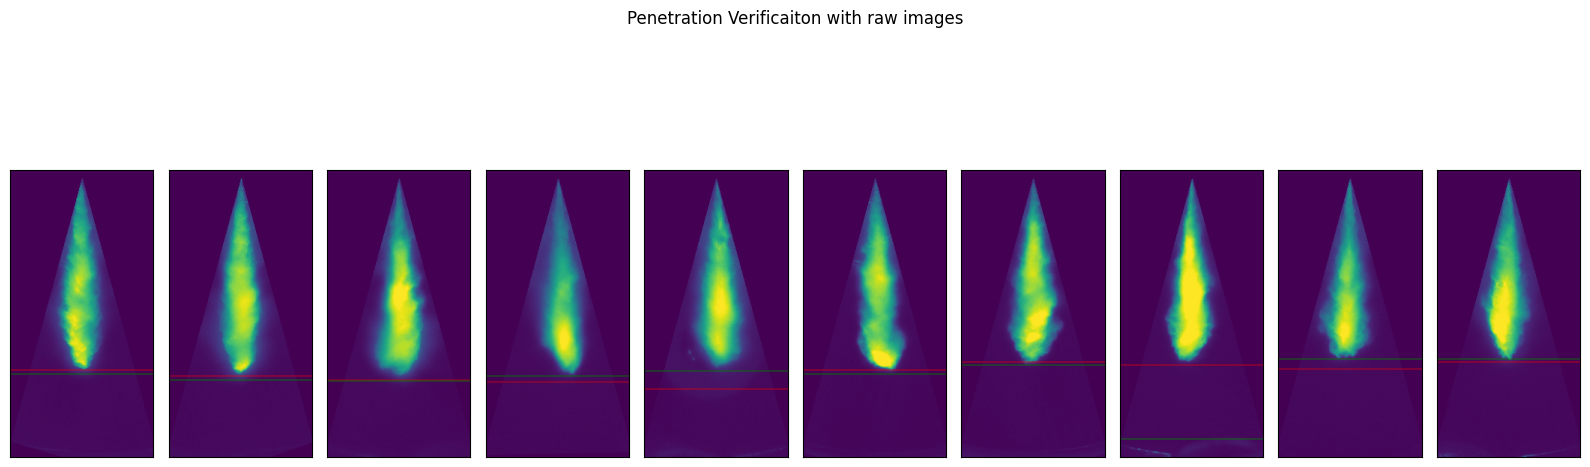

In [51]:
frame_num = 30
fig, ax = plt.subplots(1, number_of_plumes, figsize=(16, 6))

for n in range(number_of_plumes):
    ax[n].imshow(_as_numpy(xp.swapaxes(segments_raw, 2, 3)[n, frame_num, :, :]))
    ax[n].axhline(_as_numpy(penetration_cdf_all[n, frame_num]), color="r", alpha= 0.3)
    ax[n].axhline(_as_numpy(penetration_highpass[n, frame_num]+ir_), color="g", alpha=0.4)

for axis in ax.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

fig.suptitle("Penetration Verificaiton with raw images")
plt.tight_layout()

In [52]:
segments_highlight = xp.zeros_like(segments_raw)
brightness_thres = 0.5
for p in range(P):
    segments_highlight[p] = _min_max_scale(segments_raw[p])
    segments_highlight[p][segments_highlight[p] < brightness_thres ] = 0

segments_highlight[segments_highlight > 0] = 1

segments_union = segments_bw + segments_highlight 

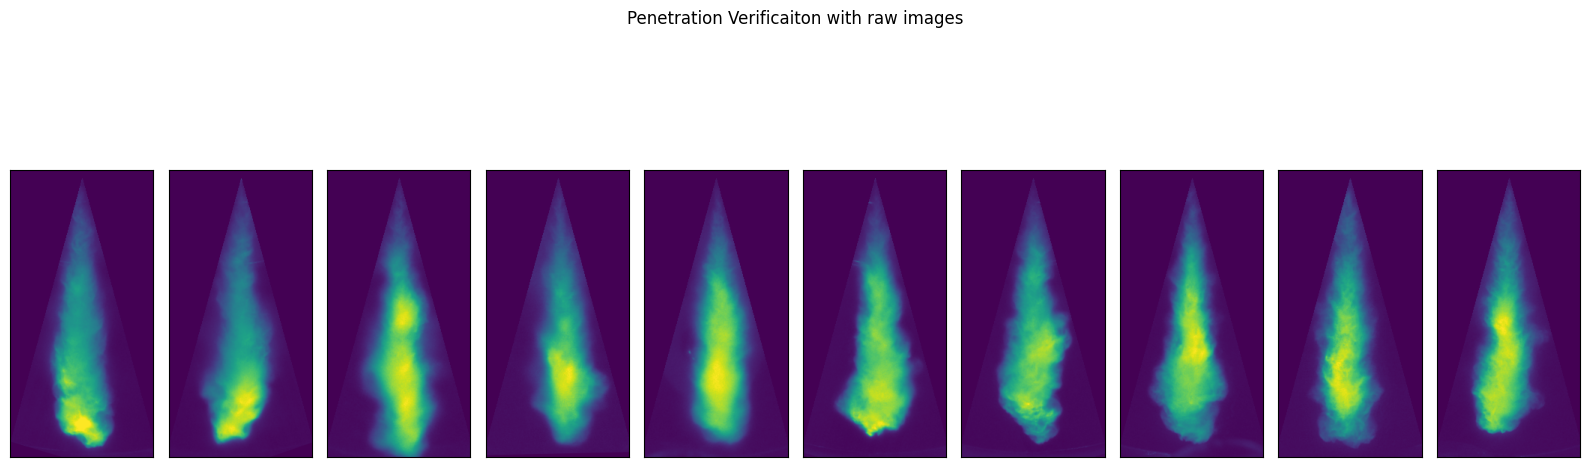

In [88]:
frame_num = 40
fig, ax = plt.subplots(1, number_of_plumes, figsize=(16, 6))

for n in range(number_of_plumes):
    ax[n].imshow(_as_numpy(xp.swapaxes(segments_raw, 2, 3)[n, frame_num, :, :]))
    # ax[n].axhline(_as_numpy(penetration_cdf_all[n, frame_num]), color="r", alpha= 0.3)
    # ax[n].axhline(_as_numpy(penetration_highpass[n, frame_num]), color="g", alpha=0.4)

for axis in ax.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

fig.suptitle("Penetration Verificaiton with raw images")
plt.tight_layout()

In [56]:
def mie_multihole_postprocessing(foreground, highpass, bw, 
                                 centre, number_of_plumes, inner_radius, outer_radius,
                                 bins=720, 
                                 highlight_compensation_threshold=0.75, 
                                 quantile = 1.0-3e-2):
    
    F, H, W = foreground.shape
    # bw = ((foreground > highlight_compensation_threshold) + bw) > 1
    
    # === Angular Signal Density Analysis ===
    # Use 720 bins for 0.5 degree resolution
    # scale = bins / 360.0

    # Compute angular signal distribution around the nozzle centre
    _, total_angular_signal_density, _ = angle_signal_density_auto(
        fg, centre[0], centre[1], N_bins=bins
    )

    # === Find Optimal Rotation Offset ===
    # Use FFT to find the best offset that aligns with plume periodicity
    offset = estimate_offset_from_fft(total_angular_signal_density, number_of_plumes)

    # Calculate rotation angles for each plume (evenly spaced with offset correction)
    angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - _as_numpy(offset)

    # === Compute Occupied Angles ===
    # Create bin-wise mask and fill small gaps to get continuous plume regions
    bin_wise_mask = fill_short_false_runs(
        _triangle_binarize_gpu(xp.sum(total_angular_signal_density, axis=0), ignore_zeros=True), 
        max_len=3
        )

    # Calculate angular span of each plume region
    occupied_angles = periodic_true_segment_lengths(bin_wise_mask)
    # Average angular width per plume in degrees
    average_occupied_angle = (bin_wise_mask.sum() / bins * 360.0 / number_of_plumes).item()

    # Generate 2D angular mask from the 1D signal density
    angular_mask = generate_angular_mask_from_tf(H, W, centre, total_angular_signal_density, bins)

    ang_int_sum = _min_max_scale(xp.sum(total_angular_signal_density, axis=0))


    
    angles_refined = snap_angles_to_local_maxima(angles, ang_int_sum, window_deg=2.0, bins=bins)
    TF = triangle_binarize_gpu(median_filter(ang_int_sum, 5))

    average_occupied_angle = TF.sum()/bins*360.0/number_of_plumes

    # =============================================
    # Rotation: Highpass 
 
    # Frames, Height, Width
    F, H, W = video.shape

    # Allocate collector
    segments = []

    # Image rotation settings
    INTERPOLATION = "nearest"
    BORDER_MODE = "constant"

    # Arbitrary rotated image strip shape
    OUT_SHAPE = (int(outer_radius)//2, int(outer_radius))


    for idx, angle in enumerate(angles):
        segment, _, _ = rotate_video_nozzle_at_0_half_backend(
                hp,
                centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
                # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
                angle,
                interpolation=INTERPOLATION,
                border_mode=BORDER_MODE,
                out_shape=OUT_SHAPE,
            )
        segments.append(segment)

    segments_fg = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)

    P, F, H, W = segments_fg.shape

    plume_mask = generate_plume_mask(W, H, average_occupied_angle.get()*1.5, int(ir_))
    
    segments_fg *= xp.asarray(plume_mask[None, None, :, :])


    heatmaps = xp.sum(xp.clip(segments_fg, 0, 1), axis=2) # P, F, W

    # 1. Initialize the storage array with the same shape as penetration_td
    # We assume penetration_td is already defined in your context
    penetration_cdf_all = np.zeros((heatmaps.shape[0], heatmaps.shape[1]))

    # 2. Iterate through all available indices
    # We use the length of the map list to determine the range
    for idx in range(len(heatmaps)):
        
        # Retrieve data
        I = heatmaps[idx]

        I -= xp.median(I[:, :frames_before_SOI], axis=1, keepdims=True)

        I = xp.clip(I, 0.0, None)

        
        mask = triangle_binarize_gpu(_min_max_scale(I))
        
        # Process mask
        mask = 1 - (keep_largest_component_cuda(1 - mask))

        mask = cndi.binary_opening(mask, cp.ones((7, 3)))

        # Compute penetration curve
        xhat = penetration_cdf_front(I, mask=mask, q=quantile, min_x=10)
        pen0 = np.maximum.accumulate(xhat.get())

        # Store the result in the array
        # penetration_cdf_all[idx] = pen0
        penetration_cdf_all[idx] = pen0

    # Now penetration_cdf_all contains the computed curves for all indices
    penetration_cdf = np.maximum(0, penetration_cdf_all-ir_)


    return segments_fg, _as_numpy(penetration_cdf)

In [57]:
hp_segments, pen_cdf = mie_multihole_postprocessing(fg, hp, bw, 
                                 centre, number_of_plumes, ir_, or_)

In [58]:
# play_videos_side_by_side(((10.0*bw_segments).get().tolist()))


In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_smooth_mask(high_pass_output, blur_ksize=51, morph_ksize=15):
    """
    从高通滤波后的浮点数据中提取平滑包络。
    """
    # 1. 能量化 (Rectification)
    # 高通滤波会有负值（暗部），我们需要的是“变化的强度”，所以取绝对值或平方。
    # 这里取绝对值，类似于全波整流。
    energy_map = np.abs(high_pass_output)
    
    # 归一化到 0-1 方便后续参数调整 (可选，但推荐)
    energy_map = (energy_map - energy_map.min()) / (energy_map.max() - energy_map.min() + 1e-8)

    # 2. 形态学膨胀 (Morphological Dilation) - 可选但推荐
    # 在模糊之前，先用最大值滤波把相近的亮点“桥接”起来。
    # 这比单纯用巨大的高斯核更能保留物体的几何形状，避免过度圆滑。
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_ksize, morph_ksize))
    dilated_energy = cv2.dilate(energy_map, kernel)

    # 3. 高斯模糊 (Density Estimation)
    # 将离散的能量点融合成连续的场。
    # ksize 决定了平滑程度。
    smooth_energy = cv2.GaussianBlur(dilated_energy, (blur_ksize, blur_ksize), 0)

    # 4. 滞后阈值 (Hysteresis Thresholding) 或 单一阈值
    # 这里为了简单展示用单一阈值。
    # 因为我们之前归一化了，所以可以用 0.1 - 0.3 这样的相对值。
    thresh_val = 0.15 
    _, mask = cv2.threshold(smooth_energy, thresh_val, 1.0, cv2.THRESH_BINARY)
    
    # 转回 uint8 以便找轮廓
    mask_uint8 = (mask * 255).astype(np.uint8)
    
    # 5. 提取最大轮廓 (假设物体是最大的那个)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    result_contour = None
    if contours:
        result_contour = max(contours, key=cv2.contourArea)
        
    return smooth_energy, mask_uint8, result_contour



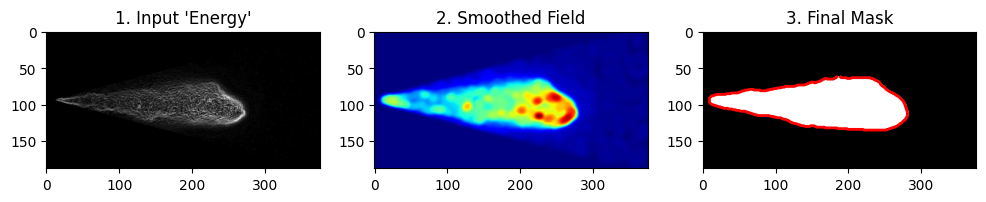

In [60]:
img = hp_segments[3, 30].get()

# --- 模拟你的场景 ---
# 假设 img 是你的原始高通滤波数据（模拟一些正负波动）
# 这里用你之前的二值图模拟一下“能量分布”
# img = cv2.imread('image_5b9735.png', 0).astype(np.float32) / 255.0
# 模拟高通滤波后的稀疏性（让点更散一点）
# img[img < 0.5] = 0 

smooth, mask, contour = extract_smooth_mask(img, blur_ksize=11, morph_ksize=11)

# --- 可视化 ---
plt.figure(figsize=(12, 4))
plt.subplot(131); plt.title("1. Input 'Energy'"); plt.imshow(img, cmap='gray')
plt.subplot(132); plt.title("2. Smoothed Field"); plt.imshow(smooth, cmap='jet') # 仔细看这张图，就像地形图
plt.subplot(133); plt.title("3. Final Mask"); plt.imshow(mask, cmap='gray')
if contour is not None:
    # 画出轮廓
    plt.plot(contour[:, 0, 0], contour[:, 0, 1], 'r-', linewidth=2)
plt.show()

In [61]:
import cupy as cp
import cupyx.scipy.ndimage as ndi

def batch_extract_smooth_mask_gpu(tensor_4d, blur_sigma=5, dilate_ksize=5, threshold=0.2):
    """
    对 (P, F, H, W) 张量的每一帧进行 "能量化 -> 膨胀 -> 高斯模糊 -> 阈值" 操作。
    全程在 GPU 上以 Batch 模式运行，无 Python 循环。

    参数:
        tensor_4d: cupy.ndarray, 形状 (P, F, H, W)，通常是高通滤波后的结果
        blur_sigma: 高斯模糊的标准差 (控制平滑度)
        dilate_ksize: 膨胀核大小 (控制连通性)，必须是奇数
        threshold: 相对阈值 (0.0 - 1.0)

    返回:
        binary_mask: cupy.ndarray, uint8 类型 (0 或 1)
    """
    # 1. 能量化 (Rectification)
    # 取绝对值将“变化”转换为“能量强度”
    energy = cp.abs(tensor_4d)

    # 2. 批处理形态学膨胀 (Morphological Dilation)
    # OpenCV 的 dilate 是 2D 的。我们在 4D 张量上做，需要指定 "footprint" (核)。
    # 我们只希望在 H, W 维度膨胀，不希望跨帧 (F) 或跨样本 (P) 混合。
    # footprint 形状: (1, 1, K, K)
    if dilate_ksize > 1:
        footprint = cp.ones((1, 1, dilate_ksize, dilate_ksize), dtype=bool)
        # grey_dilation 对浮点数相当于 Max Filter，即形态学膨胀
        energy = ndi.grey_dilation(energy, footprint=footprint)

    # 3. 批处理高斯模糊 (Batch Gaussian Blur)
    # sigma 指定为 (0, 0, sigma, sigma)
    # 前两个维度 (P, F) sigma 为 0，表示不进行帧间混合，只在空间 (H, W) 模糊
    energy = ndi.gaussian_filter(energy, sigma=(0, 0, blur_sigma, blur_sigma))

    # 4. 向量化 Min-Max 归一化 (Per-Frame Normalization)
    # 为了应用统一的相对阈值，我们需要把每一帧归一化到 [0, 1]
    # keepdims=True 保持形状为 (P, F, 1, 1)，利用广播机制进行计算
    min_val = cp.min(energy, axis=(-2, -1), keepdims=True)
    max_val = cp.max(energy, axis=(-2, -1), keepdims=True)
    
    # 防止除以零
    range_val = max_val - min_val
    range_val[range_val < 1e-8] = 1e-8
    
    normed_energy = (energy - min_val) / range_val

    # 5. 阈值化 (Thresholding)
    mask = (normed_energy > threshold).astype(cp.uint8)

    return mask

# --- 使用示例 ---
# 假设 input_tensor 是 GPU 上的数据，形状 (2, 100, 512, 512)
# input_tensor = cp.random.randn(2, 100, 512, 512).astype(cp.float32)


In [83]:

bw_segments = batch_extract_smooth_mask_gpu(hp_segments, blur_sigma=3, dilate_ksize=11,threshold=0.2)
# mask 现在也是 (2, 100, 512, 512) 的 0/1 张量

In [84]:
play_videos_side_by_side((cp.swapaxes(hp_segments, 2,3)).get().tolist())

In [85]:
hydraulic_delay = np.argmax(np.maximum(0, penetration_cdf_all.T-ir_) > 0, axis=0)


In [86]:
for idx, _ in enumerate(bw_segments):
    bw_segments[idx, :hydraulic_delay[idx], :, :] = 0

In [87]:
play_videos_side_by_side((cp.swapaxes((255.0*bw_segments), 2,3)).get().tolist())